<a href="https://colab.research.google.com/github/cubecloud/fool_game/blob/feature-05-new-state/fool_game_and_q_deep_learning_env_steps_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### New Import

In [1]:
!pip install git+https://github.com/cubecloud/fool_game.git@feature-05-new-state

  Cloning https://github.com/cubecloud/fool_game.git (to revision feature-05-new-state) to /tmp/pip-req-build-y43u8ijf
  Running command git clone -q https://github.com/cubecloud/fool_game.git /tmp/pip-req-build-y43u8ijf
  Running command git checkout -b feature-05-new-state --track origin/feature-05-new-state
  Switched to a new branch 'feature-05-new-state'
  Branch 'feature-05-new-state' set up to track remote branch 'feature-05-new-state' from 'origin'.
  Created wheel for fool-game: filename=fool_game-0.2.16-cp37-none-any.whl size=27650 sha256=aa357be6076b76269fdd5776234cdf896f2ef6de208340bd47815b7246ce7cab
  Stored in directory: /tmp/pip-ephem-wheel-cache-cdk28wxb/wheels/f9/a3/15/11d115bd3262638841b40ed151f3f08fd41a04e9619fc5244e
Successfully built fool-game


In [2]:
# adding terra_ai location for using googlesync 
# for development on local drive and testing 
# in google colab or jupyter notebook 
# change this variables to your locations for development
local_drive = '/home/cubecloud/GDrive'
remote_drive = '/content/drive/MyDrive'
local_dev = '/Python/fool_game/'
remote_dev = '/Python/fool_game/'
__demo_version__ = "0.1.0"
import sys
if 'google.colab' in str(get_ipython()):
    print('Running on CoLab')
#     from google.colab import drive
#     drive.mount('/content/drive')
    DEV = f'{remote_drive}{remote_dev}'
    DRIVE = remote_drive
elif 'ipykernel' in str(get_ipython()):
    print('Running on Jupyter Notebook')
    DEV = f'{local_drive}{local_dev}'
    DRIVE = local_drive
else:
    sys.exit('Not running on CoLab or Jupyter notebook')
print(f'Adding sys path: {DEV}')
sys.path.append(DEV)
HOME = f'{DEV}data/'

#check environment 

import tensorflow
print('Checking key environment depenndecies')
!python --version
print('TensorFlow', tensorflow.__version__)
print('Keras', tensorflow.keras.__version__)


Running on CoLab
Adding sys path: /content/drive/MyDrive/Python/fool_game/
Checking key environment depenndecies
Python 3.7.10
TensorFlow 2.3.0
Keras 2.4.0


In [3]:
import collections
import numpy as np # импортируем библиотеку для работы с массивами данных
import tensorflow as tf
# from tensorflow.keras.models import Model, load_model 
# from tensorflow.keras import layers
# from tensorflow.keras.layers import Dense, Flatten, Input, Lambda, Conv2D, MaxPooling2D, Reshape, Multiply # из кераса загружаем необходимые слои для нейросети
# from tensorflow.keras.layers import BatchNormalization
# from tensorflow.keras.optimizers import RMSprop, Adam, SGD, RMSprop# из кераса загружаем выбранный оптимизатор
import time                                # модуль для операций со временными характеристиками
import matplotlib.pyplot as plt            # импортируем библиотеку для визуализации данных
import seaborn as sns
import matplotlib
import pandas as pd
import pickle as pkl
import random
import sys
import os
from datetime import datetime, timedelta
from IPython.display import clear_output 

import pytz
timezone = pytz.timezone("Europe/Moscow")
# # "магическая" команда python для запуска библиотеки в ноутбуке
# %matplotlib inline

HOME = f'/content/drive/MyDrive/Python/fool_game/data/'
from google.colab import drive
drive.mount('/content/drive')

from importlib import reload
from cardgames import foolgame
foolgame = reload(foolgame)
print(tf.__version__)
print(tf.keras.__version__)
print(foolgame.__version__)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
2.3.0
2.4.0
0.02.16


### Figshow

In [4]:
def figshow(df):
    fig = plt.figure(figsize=(26, 7))
    sns.set_style("white")
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.set_axisbelow(True)
    ax1.minorticks_on()
    ax1.grid(which='major', linestyle='-', linewidth='0.5', color='gray')
    ax1.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
    last_game = int(df["game_episode"].max())
    # N = np.arange(0, last_game+1)
    n_games = 1
    if last_game // 400 > 0:
        n_games = last_game // 400
    

    plt.plot(df.loc[(df["game_episode"] % n_games == 0), "game_episode"], 
             df.loc[(df["game_episode"] % n_games == 0), "loss"], 
             linestyle='--', color='blue', label="loss")
    plt.plot(df.loc[(df["game_episode"] % n_games == 0), "game_episode"], 
             df.loc[(df["game_episode"] % n_games == 0), "epsilon"], 
             linestyle='--', color='green', label="epsilon")
    plt.title(f"Loss & epsilon")
    plt.legend()

    ax2 = fig.add_subplot(1, 2, 2)
    ax2.set_axisbelow(True)
    ax2.minorticks_on()
    ax2.grid(which='major', linestyle='-', linewidth='0.5', color='gray')
    ax2.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
    plt.plot(df.loc[(df["game_episode"] % n_games == 0), "game_episode"],
             df.loc[(df["game_episode"] % n_games == 0), 'mean_reward'], 
             linestyle='-', color='red', label="mean_reward")
    plt.title(f"mean_reward")
    plt.legend()
    plt.show()
    pass

In [5]:
!nvidia-smi

Fri May 14 20:29:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## The DQN model


In [6]:
import torch
import torch.nn as nn        # Pytorch neural network package
import torch.optim as optim  # Pytorch optimization package

device = torch.device("cuda")

In [7]:
# Taken from 
# https://github.com/PacktPublishing/Deep-Reinforcement-Learning-Hands-On/blob/master/Chapter06/lib/dqn_model.py

# class DQN(nn.Module):
#     def __init__(self, input_shape, n_actions):
#         super(DQN, self).__init__()

#         self.conv = nn.Sequential(
#             nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
#             nn.ReLU(),
#             nn.Conv2d(32, 64, kernel_size=4, stride=2),
#             nn.ReLU(),
#             nn.Conv2d(64, 64, kernel_size=3, stride=1),
#             nn.ReLU()
#         )

#         conv_out_size = self._get_conv_out(input_shape)
#         self.fc = nn.Sequential(
#             nn.Linear(conv_out_size, 512),
#             nn.ReLU(),
#             nn.Linear(512, n_actions)
#         )

#     def _get_conv_out(self, shape):
#         o = self.conv(torch.zeros(1, *shape))
#         return int(np.prod(o.size()))

#     def forward(self, x):
#         conv_out = self.conv(x).view(x.size()[0], -1)
#         return self.fc(conv_out)


class DQN(nn.Module):
  
  def __init__(self, input_dim, output_dim):
      super(DQN, self).__init__()
      self.input_dim = input_dim
      self.output_dim = output_dim
      
      self.fc = nn.Sequential(
          nn.Linear(self.input_dim, 128),
          nn.ReLU(),
          nn.Linear(128, 256),
          nn.ReLU(),
          nn.Linear(256, self.output_dim),
          nn.Tanh()
          )
  def forward(self, state):
      qvals = self.fc(state)
      return qvals

In [8]:
players_num = 2
test_net = DQN((4536), 37).to(device)
print(test_net)

DQN(
  (fc): Sequential(
    (0): Linear(in_features=4536, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=37, bias=True)
    (5): Tanh()
  )
)


In [9]:
Experience = collections.namedtuple('Experience', field_names=['state', 'action', 'valid_action_lst','reward', 'done', 'next_state'])
class ExperienceReplay:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = collections.deque(maxlen=capacity)
        pass

    def __len__(self):
        return len(self.buffer)

    def get_length(self):
        return self.__len__()

    def append(self, experience):
        self.buffer.append(experience)
        pass

    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        states, actions, valid_actions_lst, rewards, dones, next_states = zip(*[self.buffer[idx] for idx in indices])
        return (np.array(states, dtype=np.float32), 
                np.array(actions, dtype=np.int64), 
                np.array(valid_actions_lst), 
                np.array(rewards, dtype=np.float32),
                np.array(dones, dtype=np.uint8), 
                np.array(next_states, dtype=np.float32))

    def save(self, file_path, buffer_length=10000):
        len_buffer = len(self.buffer)
        with open(file_path, "wb") as f:
            print('Save exp buffer...')
            if not (self.capacity is None) \
                    and (len_buffer < self.capacity) \
                    and (len_buffer < buffer_length):
                buffer_length = len_buffer
            else:
                buffer_length = len_buffer
            states, actions, valid_actions_lst, rewards, dones, next_states = \
                zip(*[self.buffer[idx] for idx in range(len(self.buffer) - buffer_length, len(self.buffer))])
            pkl.dump([states, actions, valid_actions_lst, rewards, dones, next_states], f)
            del [states, actions, valid_actions_lst, rewards, dones, next_states]
            pass

    def load(self, file_path):
        with open(file_path, "rb") as f:
            print('Loading exp buffer...')
            # self.buffer = pkl.load(f)
            states, actions, valid_actions_lst, rewards, dones, next_states = pkl.load(f)
            for state, action, valid_action_lst, reward, done, next_state in zip(states, actions, valid_actions_lst, rewards, dones, next_states):
                exp = Experience(state, action, valid_action_lst, reward, done, next_state)
                self.buffer.append(exp)
            del [states, actions, valid_actions_lst, rewards, dones, next_states]
        pass

# Pytorch *Agent*

In [10]:
class Agent:
    def __init__(self, 
                 env, 
                 exp_buffer,
                 exp_buffer_size = 100000):
        self.env = env
        self.observer_player = env.observer_player
        self.exp_buffer = exp_buffer
        self.exp_buffer_size = exp_buffer_size
        self.verbose = False
        self.debug_verbose = 1
        self._reset()
        pass

    def _reset(self):
        self.state =np.reshape(self.env.reset(), 4536)
        self.total_reward: float = 0.0
        self.env.verbose = self.verbose
        self.env.debug_verbose = self.debug_verbose
        self.env.step(0, first_step=True)
        pass

    def play_step(self, net, epsilon=0.0, device="cpu"):
        done_reward = None
        self.env.epsilon = epsilon
        step_valid_actions = self.env.pl[self.observer_player].analyze()
        if np.random.random() < epsilon:
            action = random.choice(step_valid_actions)
        else:
            state_a = np.array([self.state], copy=False)
            state_v = torch.tensor(state_a).to(device)
            q_vals_v = net(state_v)
            _, act_v = torch.max(q_vals_v, dim=1)
            action = int(act_v.item())
            # state_a = np.array([self.state], copy=False)
            # state_tensor = tf.convert_to_tensor(state_a)
            # q_values = nnmodel(state_tensor, training=False)
            # # with np.printoptions(precision=3, suppress=True):
            # #     print(q_values.numpy())
            # valid_masks = tf.one_hot(valid_action_list, self.env.num_actions)
            # # with np.printoptions(precision=3, suppress=True):
            # #     print(masks.numpy())
            # valid_q_values = tf.expand_dims(tf.reduce_sum(tf.multiply(q_values, valid_masks), axis=0), 0)
            # # with np.printoptions(precision=3, suppress=True):
            # #     print(valid_q_values.numpy())
            # action = np.argmax(valid_q_values)
            # # print(self.action, action_list, action)
            if not (action in step_valid_actions):
                # action = step_valid_actions[0]
                action = random.choice(step_valid_actions)
        ''' 
        step_epsilon - setting to 1.0 - totally random action from agent 
        trying to learn - how to play valid actions (index + zero (pass)) 
        '''
        new_state, reward, is_done, info = self.env.step(action, step_epsilon=1.0)
        new_state = np.reshape(new_state, 4536)
        # if self.verbose:
            # print("Last action", action)
            # print(info)

        self.total_reward += reward
        exp = Experience(self.state, action, step_valid_actions, reward, is_done, new_state)
        self.exp_buffer.append(exp)
        self.state = new_state
        if is_done:
            done_reward  = self.total_reward
            self.verbose = False
            self.debug_verbose = 1
            self._reset()
        return done_reward

In [11]:
players_num = 2
num_actions=37

sync_target_turns = 1000       
replay_start_size = 100000       # start replay at turn_idx

net = DQN((4536), 37).to(device)
target_net = DQN((4536), 37).to(device)

buffer = ExperienceReplay(replay_start_size)
environment = foolgame.Environment(players_num,
                                   env_type="dummy",
                                   observer_player=1,
                                   nnmodel=None)
game_table = Agent(environment,
                   exp_buffer=buffer)

In [12]:
MEAN_REWARD_BOUND = 0.85         

gamma = 0.99                                   
batch_size = 32                   

eps_start = 1.0
eps_decay = .999985             #changed start from .999985
eps_min = 0.07                  

In [13]:
model_weights_save_name = 'fool_cardgame_weights'
history_csv_name = 'fool_cardgame_hst.csv'
exp_pkl_name = 'fool_cardgame_exp.pkl'
cols = ['game_episode',
        'turns',  
        'time', 
        'loss',
        'epsilon',
        'mean_reward', 
       ]

def get_pd_data(pdfile):
  df_data = pd.read_csv(os.path.join(HOME, pdfile), index_col=0)
  return df_data

def add_data_to_pd(df_data, _game_episode, _turns, _time, _loss, _epsilon, _mean_reward):
  df_data = df_data.append({'game_episode': _game_episode,
                            'turns': _turns,
                            'time': _time,
                            'loss': _loss,
                            'epsilon': _epsilon,
                            'mean_reward': _mean_reward,
                            }, ignore_index=True)
  # print(self.df.to_string())
  return df_data
  
def load_checkpoint(save_name):
    pd_file_path =  os.path.join(HOME, history_csv_name)
    if os.path.exists(pd_file_path):    
      df = get_pd_data(pd_file_path)
      pd_start_game= int(df.game_episode.max())
    else:
      pd_start_game = 0
      df = pd.DataFrame(columns=cols)
    start_game = 0
    mean_reward = 0
    rewards_in_row = []
    dirlist = os.listdir(HOME)
    for i in range (len(dirlist)):
      filename = dirlist[i]
      if save_name in filename:
        if '_' in filename: 
          try: 
            epoch = int((filename.split('_')[-1]).split('.')[-2])
          except ValueError:
            epoch = 0
          if epoch > start_game:
            start_game = epoch
    if pd_start_game > start_game:
      df.drop(index = [i for i in range(start_game+1, pd_start_game+1)], axis=0, inplace=True)
    if start_game > 0:
      file_path = os.path.join(HOME, f'{save_name}_{start_game}.h5')
      net.load_state_dict(torch.load(file_path))
      target_net.load_state_dict(torch.load(file_path))

      print(f"Loaded {file_path} save, for model & model_target. Starting training from {start_game}")
      # last epoch +1
      epsilon = float(df.loc[(df["game_episode"]==start_game), "epsilon"].item())
      mean_reward = float(df.loc[(df["game_episode"]==start_game), "mean_reward"].item())
    else:
      epsilon = 1.0
      print(f"Starting from scratches. Starting game = {start_game}")
      rewards_in_row = []
    return df, start_game, epsilon, mean_reward, rewards_in_row

df, start_game, epsilon, mean_reward, rewards_in_row = load_checkpoint(model_weights_save_name)

if start_game != 0:
  turn_idx = int(df.turns.max())
  figshow(df)
  game_episode = start_game
  total_rewards = []
  total_rewards = df.loc[(df["game_episode"]<=start_game) &(df["game_episode"]>=start_game-100), "mean_reward"].values.tolist()
  # epsilon = 0.1
  learning_rate = 0.00025
  adam_hat = 1e-8
  game_time = 0
  if game_episode > 200:
    lr_decay = 200/game_episode
    learning_rate = learning_rate * lr_decay
    if learning_rate < adam_hat:
      learning_rate = adam_hat
else:
  turn_idx = 0
  mean_reward = 0
  game_episode = -1
  epsilon = eps_start
  total_rewards = []
  learning_rate = 0.00025 

print(df.tail(15).to_string())
print(f'Start game episode:', start_game)
print('Turn index:', turn_idx)
print('Epsilon:', epsilon)
print('Learning rate:', learning_rate)
print('Mean reward on last game episode:', mean_reward)
print(f'_mean_ of Total rewards for last 100 games: {np.mean(total_rewards[-100:]) if total_rewards else None}')

exp_file_path = os.path.join(HOME, f'{exp_pkl_name}')
if start_game != 0:
  if os.path.exists(exp_file_path):
    buffer.load(exp_file_path)
  else:
    msg = f"Warning: pickle Exp file not found, starting without" 
    print(msg)

time_sum = int(df["time"].sum())
print(f'Model learning {start_game} games and {timedelta(seconds=time_sum)}')

Starting from scratches. Starting game = 0
Empty DataFrame
Columns: [game_episode, turns, time, loss, epsilon, mean_reward]
Index: []
Start game episode: 0
Turn index: 0
Epsilon: 1.0
Learning rate: 0.00025
Mean reward on last game episode: 0
_mean_ of Total rewards for last 100 games: None
Model learning 0 games and 0:00:00


        game_episode      turns      time      loss   epsilon  mean_reward
119951      119951.0  6385536.0  0.470081  0.000173  0.170978    -0.560059
119952      119952.0  6385583.0  0.266194  0.001633  0.170976    -0.560059
119953      119953.0  6385643.0  0.361322  0.000692  0.170973    -0.540039
119954      119954.0  6385721.0  0.448086  0.000175  0.170971    -0.560059
119955      119955.0  6385756.0  0.196486  0.000787  0.170968    -0.560059
119956      119956.0  6385794.0  0.215372  0.000344  0.170966    -0.560059
119957      119957.0  6385853.0  0.346369  0.091853  0.170963    -0.580078
119958      119958.0  6385905.0  0.293790  0.000093  0.170960    -0.600098
119959      119959.0  6385943.0  0.212196  0.000222  0.170958    -0.600098
119960      119960.0  6385978.0  0.191678  0.000084  0.170955    -0.600098
119961      119961.0  6386041.0  0.363847  0.000411  0.170953    -0.580078
119962      119962.0  6386117.0  0.439428  0.000402  0.170950    -0.560059
119963      119963.0  638

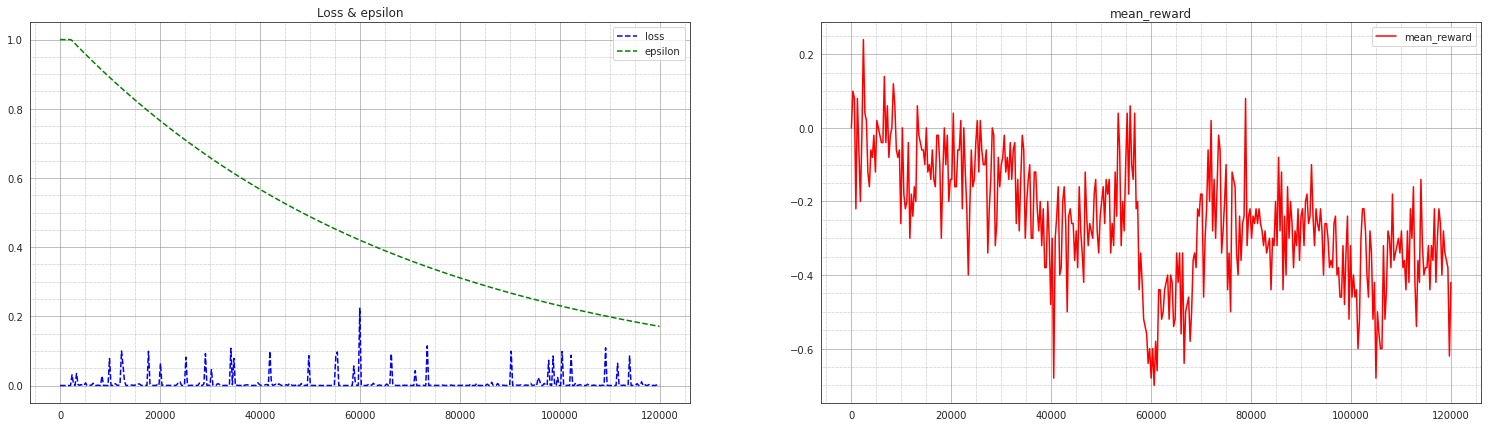

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)


game_episode: 000000120100, turn: 6394462, epsilon: 0.171, mean reward: -0.480, loss: 0.0013, last reward -1.0, episodes time: 62.6652 sec
game_episode: 000000120200, turn: 6400467, epsilon: 0.170, mean reward: -0.200, loss: 0.0001, last reward -1.0, episodes time: 35.5595 sec
game_episode: 000000120300, turn: 6406509, epsilon: 0.170, mean reward: -0.260, loss: 0.0027, last reward 1.0, episodes time: 35.5048 sec
game_episode: 000000120400, turn: 6412441, epsilon: 0.170, mean reward: -0.480, loss: 0.0005, last reward 1.0, episodes time: 35.3588 sec
game_episode: 000000120500, turn: 6418333, epsilon: 0.170, mean reward: -0.460, loss: 0.0001, last reward 1.0, episodes time: 34.4147 sec
game_episode: 000000120600, turn: 6424309, epsilon: 0.169, mean reward: -0.420, loss: 0.0027, last reward -1.0, episodes time: 35.7049 sec
game_episode: 000000120700, turn: 6430441, epsilon: 0.169, mean reward: -0.440, loss: 0.0248, last reward 1.0, episodes time: 35.3048 sec
game_episode: 000000120800, tur

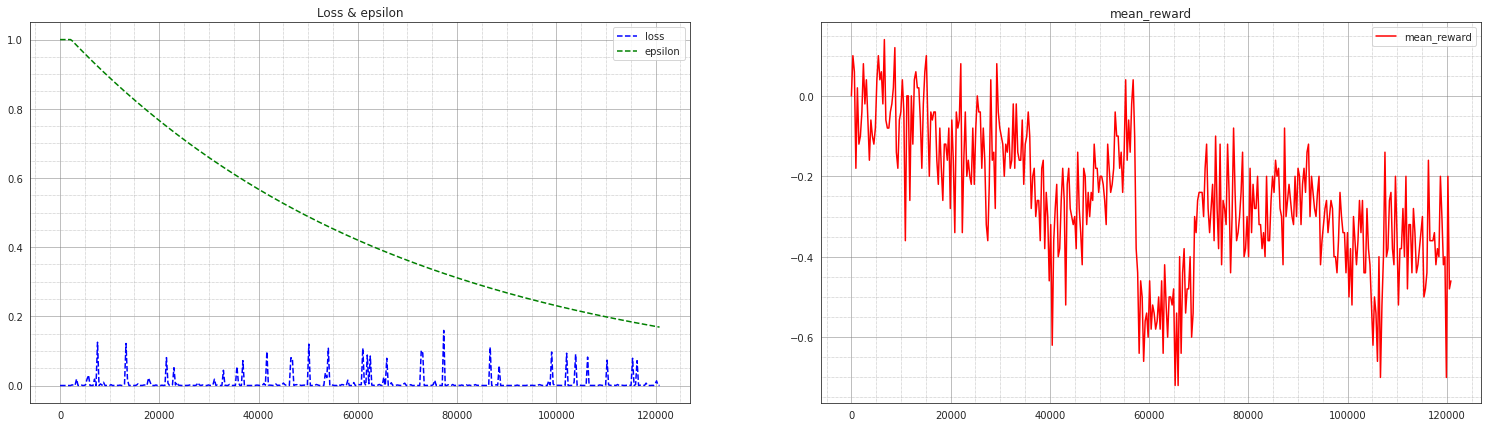

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)


game_episode: 000000121100, turn: 6454786, epsilon: 0.168, mean reward: -0.500, loss: 0.0001, last reward -1.0, episodes time: 38.9784 sec
game_episode: 000000121200, turn: 6460644, epsilon: 0.168, mean reward: -0.640, loss: 0.0014, last reward -1.0, episodes time: 33.4348 sec
game_episode: 000000121300, turn: 6466735, epsilon: 0.168, mean reward: -0.440, loss: 0.0001, last reward -1.0, episodes time: 35.3683 sec
game_episode: 000000121400, turn: 6472737, epsilon: 0.167, mean reward: -0.460, loss: 0.0010, last reward -1.0, episodes time: 35.0751 sec
game_episode: 000000121500, turn: 6478595, epsilon: 0.167, mean reward: -0.660, loss: 0.0043, last reward -1.0, episodes time: 33.9598 sec
game_episode: 000000121600, turn: 6484720, epsilon: 0.167, mean reward: -0.540, loss: 0.0024, last reward -1.0, episodes time: 36.4854 sec
game_episode: 000000121700, turn: 6490900, epsilon: 0.167, mean reward: -0.380, loss: 0.0002, last reward -1.0, episodes time: 35.9381 sec
game_episode: 000000121800,

In [ ]:
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

msg_display = True
best_mean_reward = None
num_actions = 37
loss_numpy = 0
loss = 0
start_datetime = datetime.now(timezone)
print(">>>Training starts at ", start_datetime)
start_time = time.time()
episodes_start_time = time.time()

while True:
        turn_idx += 1
        if len(buffer) < replay_start_size:
            epsilon = 1.0
        reward = game_table.play_step(net, epsilon=epsilon, device=device)
        if reward is not None:
            epsilon = max(epsilon*eps_decay, eps_min)
            reward = np.float16(reward)
            game_episode += 1
            total_rewards.append(reward)
            if len(total_rewards) > 100:
              mean_reward = np.mean(total_rewards[-100:])
              del total_rewards[:1]
            msg = f"\rgame_episode: {game_episode:07d}, turn: {turn_idx:09d}, epsilon: {epsilon:.3f}, " \
                  f"mean reward: {mean_reward:.3f}, loss: {loss_numpy:.4f}, " \
                  f"last reward {reward}"

            if (best_mean_reward is None or best_mean_reward < mean_reward) \
              and game_episode > 1000:
                best_mean_reward = mean_reward
                if best_mean_reward is not None:
                    torch.save(net.state_dict(), os.path.join(HOME, f'{model_weights_save_name}_{game_episode:002d}.h5'))
                    msg = f"\rgame_episode: {game_episode:07d}, turn: {turn_idx:0d}, epsilon: {epsilon:.3f}, " \
                    f"mean reward: {mean_reward:.3f}, loss: {loss_numpy:.4f}, " \
                    f"last reward {reward}"
                    msg = f'{msg}. Best mean reward updated {best_mean_reward:.3f}'
                    msg_display = True

            if mean_reward > MEAN_REWARD_BOUND \
              and len(buffer) > replay_start_size \
              and epsilon == 0.02:
                end_time = time.time()
                game_time = end_time - start_time 
                start_time  = time.time()
                print(f'{msg}, time: {game_time:.4f} sec')    
                print("Solved in %d turns!" % turn_idx)
                loss_numpy = loss_t.item()
                # if tf.is_tensor(loss):
                    # loss_numpy = tf.keras.backend.get_value(loss)
                df = add_data_to_pd(df, game_episode, turn_idx, game_time, loss_numpy, epsilon, mean_reward)
                df.to_csv(os.path.join(HOME, history_csv_name), encoding='utf-8')
                break
            end_time = time.time()
            game_time = end_time - start_time 
            start_time  = time.time()

            # if tf.is_tensor(loss):
                # loss_numpy = tf.keras.backend.get_value(loss)    
            if game_episode % 100 == 0 or msg_display:
              episodes_end_time = time.time()
              episodes_time = episodes_end_time - episodes_start_time 
              episodes_start_time  = time.time() 
              print(f'{msg}, episodes time: {episodes_time:.4f} sec')
              msg_display = False
            df = add_data_to_pd(df, game_episode, turn_idx, game_time, loss_numpy, epsilon, mean_reward)
            if (game_episode % 500 == 0) and (game_episode != 0):
                df.to_csv(os.path.join(HOME, history_csv_name), encoding='utf-8')
            if (game_episode % 2500 == 0) and (game_episode != 0) and (turn_idx >= replay_start_size):
                print('Saving weights...')
                torch.save(net.state_dict(), os.path.join(HOME, f'{model_weights_save_name}_{game_episode:002d}.h5'))
                buffer.save(exp_file_path)
            if game_episode % 1000 == 0:
                figshow(df)
            if (game_episode % 10000 == 0) and (game_episode != 0):  
                clear_output()
                print(df.tail(50).to_string())
                figshow(df)
        if len(buffer) < replay_start_size:
            continue

        batch = buffer.sample(batch_size)
        states, actions, valid_actions_lst, rewards, dones, next_states = batch

        states_v = torch.tensor(states).to(device)
        next_states_v = torch.tensor(next_states).to(device)
        actions_v = torch.tensor(actions).to(device)
        rewards_v = torch.tensor(rewards).to(device)
        done_mask = torch.ByteTensor(dones).to(device)

        state_action_values = net(states_v).gather(1, actions_v.unsqueeze(-1)).squeeze(-1)

        next_state_values = target_net(next_states_v).max(1)[0]

        next_state_values[done_mask] = 0.0

        next_state_values = next_state_values.detach()

        expected_state_action_values = next_state_values * gamma + rewards_v

        loss_t = nn.MSELoss()(state_action_values, expected_state_action_values)

        optimizer.zero_grad()
        loss_t.backward()
        optimizer.step()
        loss_numpy = loss_t.item()

        if turn_idx % sync_target_turns == 0:
            # update the the target network with new weights
            # print("Synchronizing models...")
            target_net.load_state_dict(net.state_dict())
            # model_target.set_weights(model.get_weights())

print('Saving weights...')
torch.save(net.state_dict(), os.path.join(HOME, f'{model_weights_save_name}_{game_episode:002d}.h5'))
buffer.save(exp_file_path)
figshow(df)

end_datetime = datetime.now(timezone)
print(">>>Training ends at ", end_datetime)
train_time = end_datetime-start_datetime
print(f'Model trained:', train_time)
